In [1]:
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV


In [2]:
seed = 42

data_dir = Path(r"C:\Users\patka\Downloads\Vision_artificial\archive")

In [3]:
param_grid = {
    "n_estimators": [50, 100, 200, 300, 500]
}

In [4]:
def listar_imagenes(data_dir: Path):
    images = []
    labels = []
    ids = []
    for label_dir in sorted([p for p in data_dir.iterdir() if p.is_dir()]):
        label_name = label_dir.name
        for img_path in label_dir.rglob("*"):
            if img_path.suffix.lower() in ['.jpg','.jpeg','.png']:
                images.append(img_path)
                labels.append(label_dir.name)
                image_id = img_path.stem
                ids.append(image_id)
    return pd.DataFrame({"image_path": images,  "image_id": ids, "label": labels})

In [5]:
if not data_dir.exists():
    raise FileNotFoundError(f"No se encontró {data_dir}. Coloca tus imágenes en esa ruta o modifica data_dir en la celda.")

df = listar_imagenes(data_dir)
print(f"Total imágenes encontradas: {len(df)}")
df.head(-5)

Total imágenes encontradas: 70549


,image_path,image_id,label
0,C:\Users\patka\Downloads\Vision_artificial\arc...,Apple 1,Apple
1,C:\Users\patka\Downloads\Vision_artificial\arc...,Apple 10,Apple
2,C:\Users\patka\Downloads\Vision_artificial\arc...,Apple 100,Apple
3,C:\Users\patka\Downloads\Vision_artificial\arc...,Apple 101,Apple
4,C:\Users\patka\Downloads\Vision_artificial\arc...,Apple 102,Apple
...,...,...,...
70539,C:\Users\patka\Downloads\Vision_artificial\arc...,Tamotoes00990,Tomatoes
70540,C:\Users\patka\Downloads\Vision_artificial\arc...,Tamotoes00991,Tomatoes
70541,C:\Users\patka\Downloads\Vision_artificial\arc...,Tamotoes00992,Tomatoes
70542,C:\Users\patka\Downloads\Vision_artificial\arc...,Tamotoes00993,Tomatoes


In [6]:
counts = df['label'].value_counts()
print(counts)

label
Guava          19698
Apple          11185
Kiwi            8465
Mango           4154
Banana          3027
Pear            3012
Orange          3012
Peach           2629
Pitaya          2501
Plum            2298
Tomatoes        2171
Pomegranate     2167
Carambola       2080
muskmelon       2078
Persimmon       2072
Name: count, dtype: int64


In [7]:
def extract_color_histogram(image_path, size=(320,258), bins=(8,8,8)): 
    img = Image.open(image_path).convert('RGB') 
    img = img.resize(size) 
    arr = np.array(img) 
    # histograma 3D 
    hist, _ = np.histogramdd(arr.reshape(-1,3), bins=bins, range=[(0,256),(0,256),(0,256)]) 
    hist = hist.flatten() 
    hist = hist / hist.sum() # normalizar 
    return hist

X = [] 
y = [] 
for row in tqdm(df.itertuples(), total=len(df)): 
    try: 
        feat = extract_color_histogram(row.image_path) 
        X.append(feat) 
        y.append(row.label) 
    except Exception: 
        continue

X = np.array(X) 
y = np.array(y)

  0%|          | 0/70549 [00:00<?, ?it/s]

In [8]:
#El modelo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

rf = RandomForestClassifier(
    random_state=seed,
    n_jobs=-1,        # usa todos los cores
    class_weight="balanced"  # opcional pero recomendable
)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

rf = RandomForestClassifier(n_estimators=200, random_state=seed) 
rf.fit(X_train, y_train)


import joblib 
joblib.dump(rf, 'rf_color_hist.pkl')

Fitting 5 folds for each of 5 candidates, totalling 25 fits


['rf_color_hist.pkl']

In [9]:
y_pred = rf.predict(X_test) 
print('Accuracy RF:', accuracy_score(y_test, y_pred)) 

Accuracy RF: 0.9944720056697378


In [10]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       Apple       0.99      1.00      0.99      2237
      Banana       1.00      0.95      0.97       606
   Carambola       1.00      1.00      1.00       416
       Guava       1.00      1.00      1.00      3940
        Kiwi       0.99      1.00      1.00      1693
       Mango       0.97      0.99      0.98       831
      Orange       1.00      1.00      1.00       602
       Peach       1.00      1.00      1.00       526
        Pear       0.98      0.99      0.99       602
   Persimmon       1.00      1.00      1.00       414
      Pitaya       1.00      1.00      1.00       500
        Plum       1.00      1.00      1.00       460
 Pomegranate       1.00      0.99      1.00       433
    Tomatoes       1.00      0.99      1.00       434
   muskmelon       0.99      0.96      0.98       416

    accuracy                           0.99     14110
   macro avg       0.99      0.99      0.99     14110
weighted avg       0.99   

<Figure size 2400x2000 with 0 Axes>

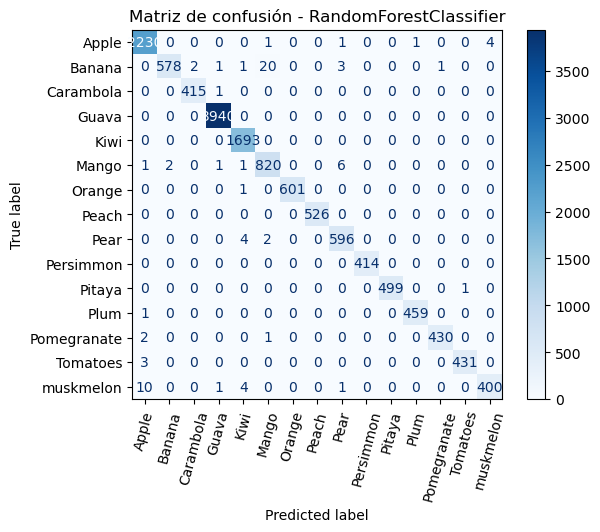

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(24, 20))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot(cmap=plt.cm.Blues, xticks_rotation=75)
plt.title("Matriz de confusión - RandomForestClassifier")
plt.show()
plt.close()

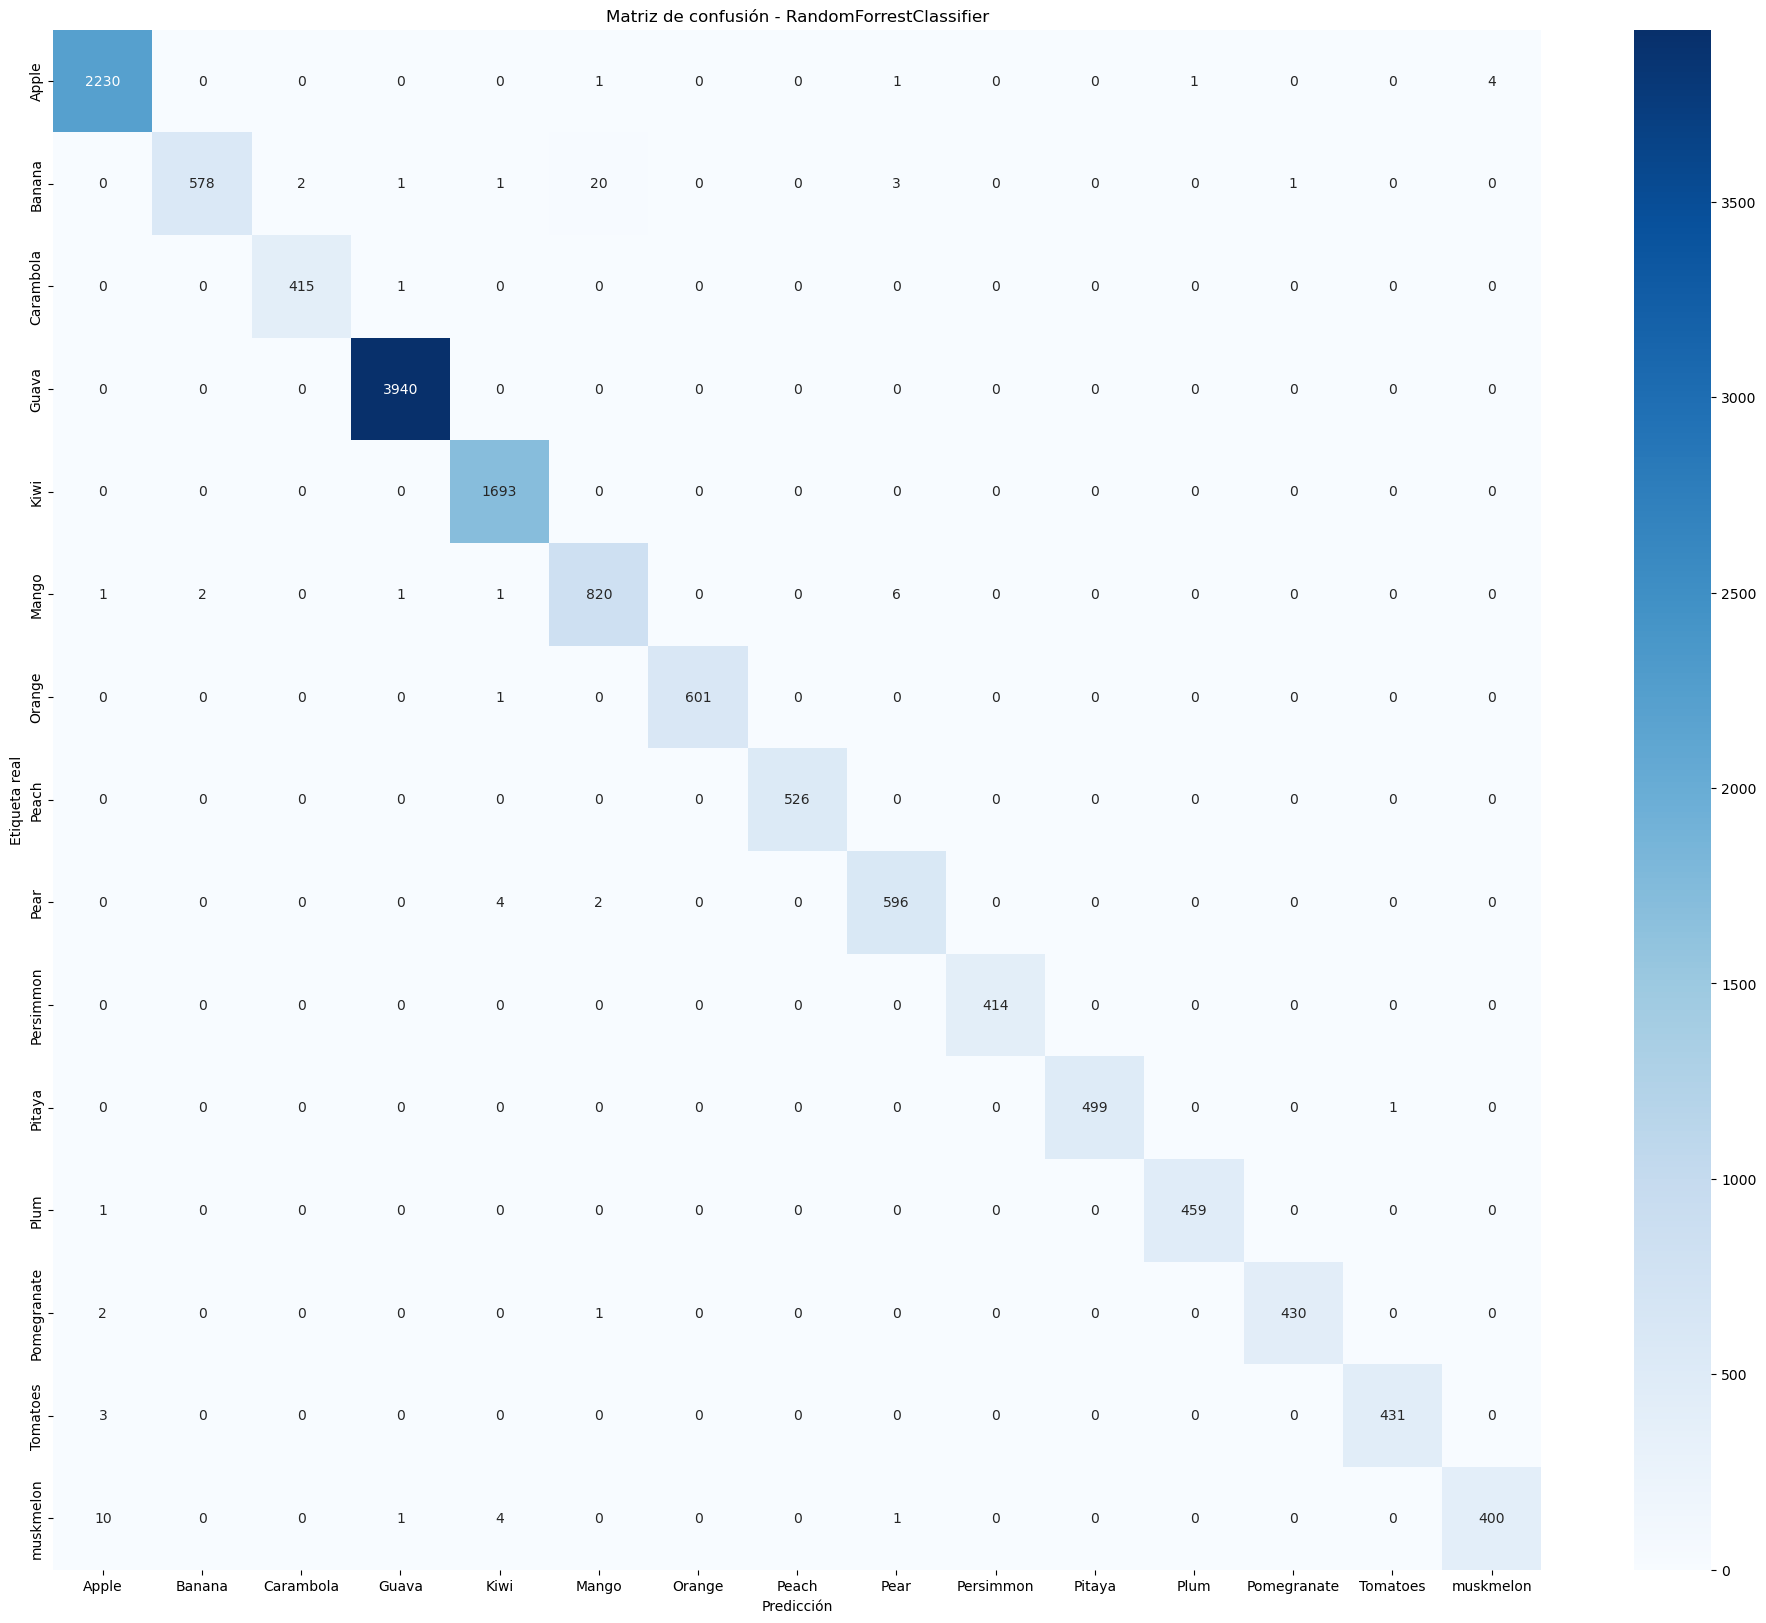

In [15]:
import seaborn as sns

plt.figure(figsize=(24, 20))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión - RandomForrestClassifier")
plt.show()

Normalized confusion matrix


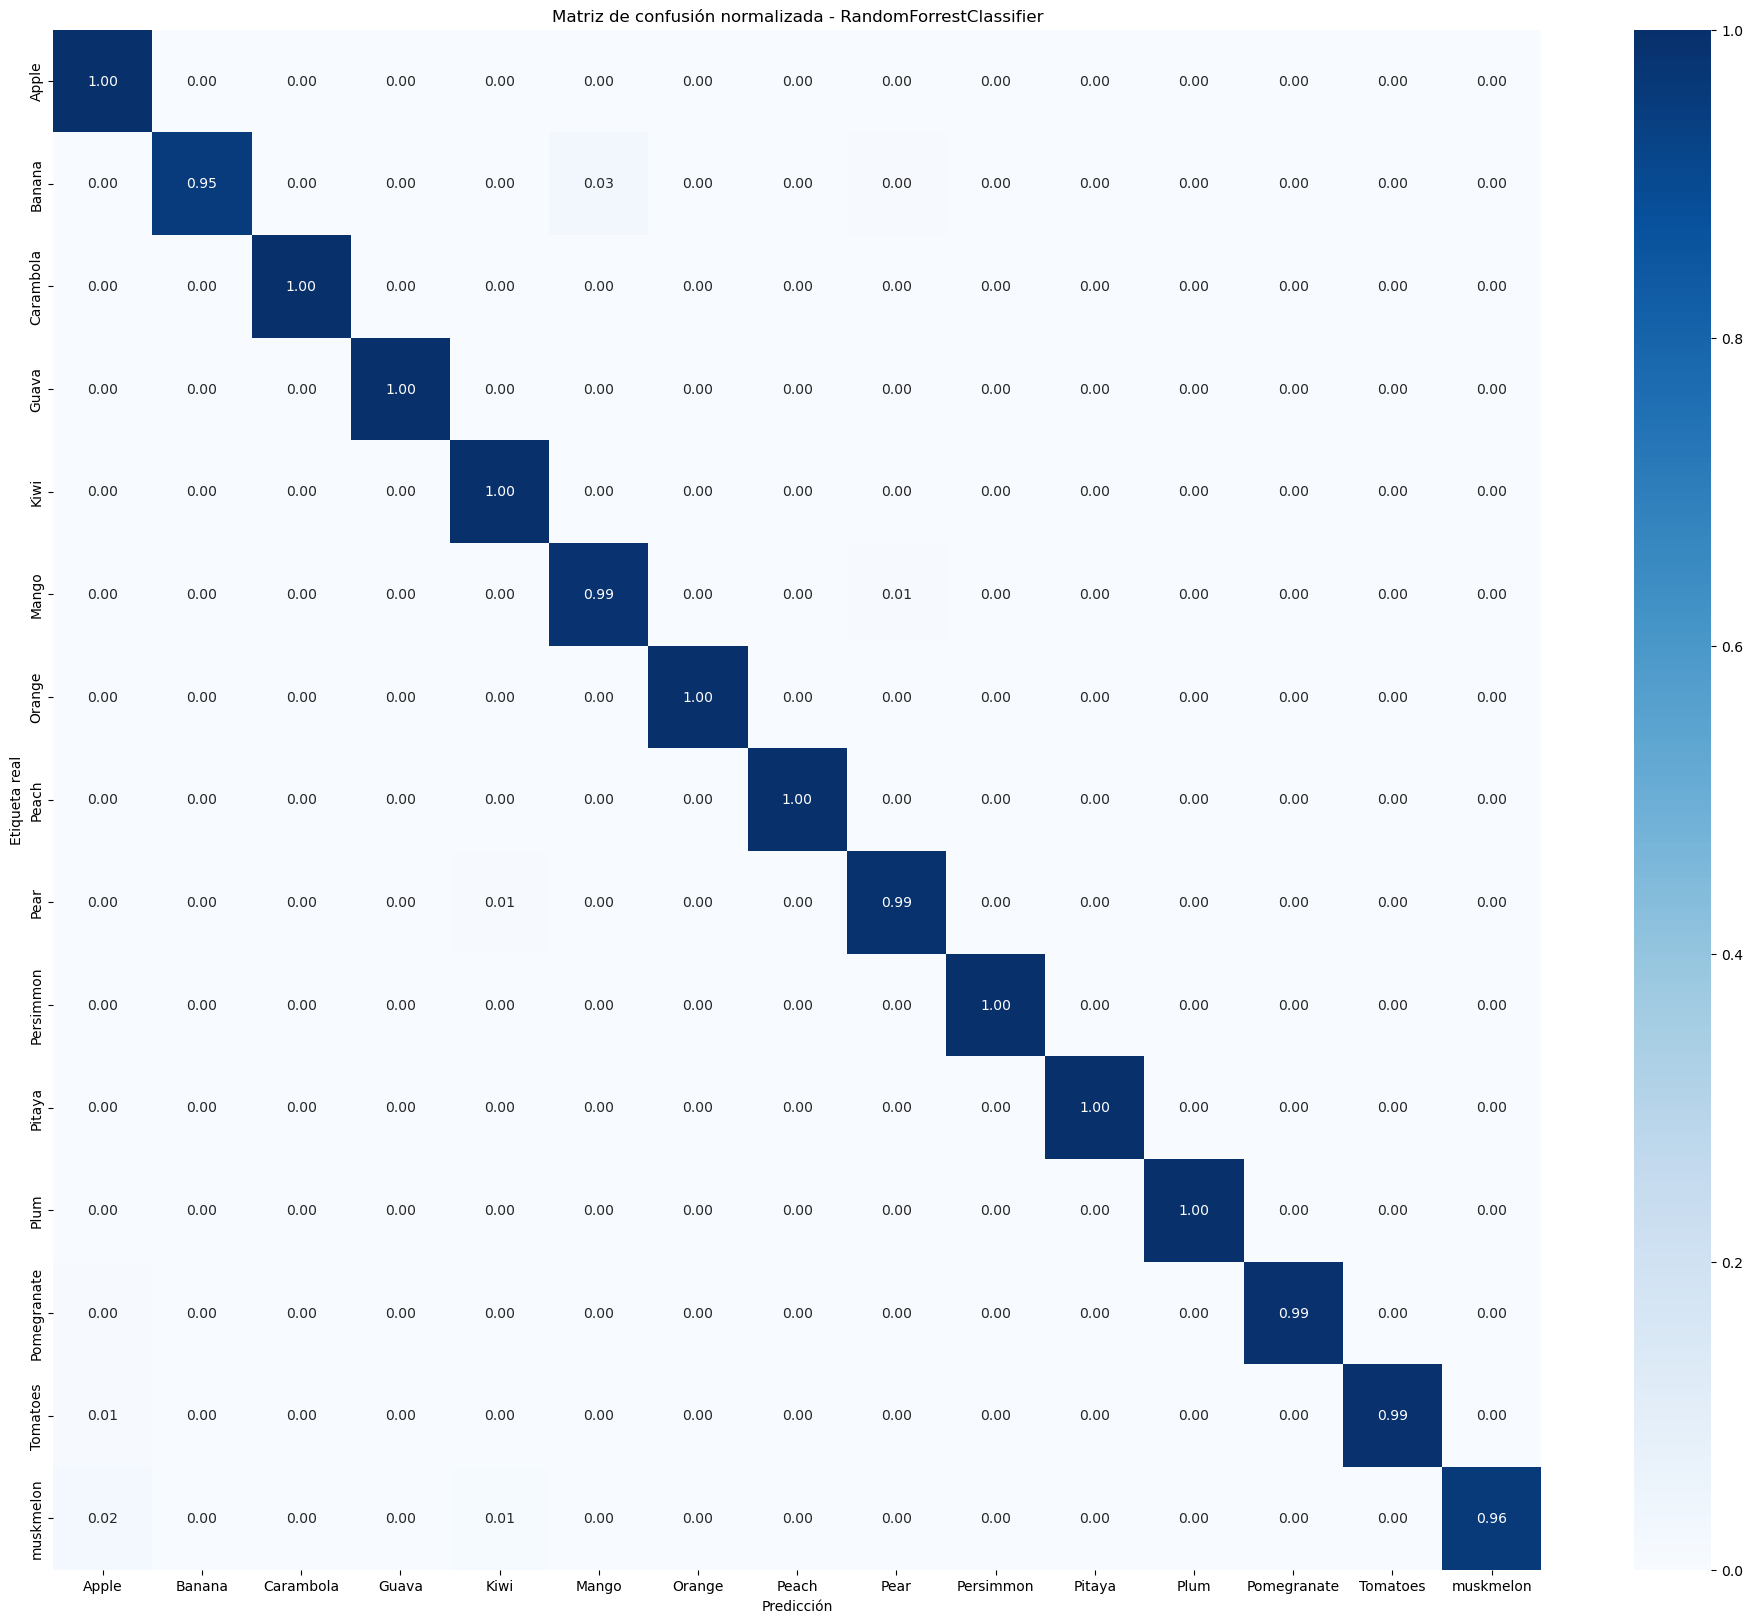

In [17]:
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')

plt.figure(figsize=(24, 20))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt='.2f',
    cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.xlabel("Predicción")
plt.ylabel("Etiqueta real")
plt.title("Matriz de confusión normalizada - RandomForrestClassifier")
plt.show()

In [18]:
#Para nuevas fotos


def extract_color_histogram(image_path, size=(128,128), bins=(8,8,8)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(size)
    arr = np.array(img)

    hist, _ = np.histogramdd(
        arr.reshape(-1, 3),
        bins=bins,
        range=[(0,256),(0,256),(0,256)]
    )

    hist = hist.flatten()
    hist = hist / hist.sum()  
    return hist


rf = joblib.load('rf_color_hist.pkl')
print("Modelo RandomForest cargado correctamente.")


no_etiquetados_dir = Path(r'C:\Users\patka\Downloads\Frutas no etiquetadas')
output_rows = []

if no_etiquetados_dir.exists():
    
    image_paths = sorted([
        p for p in no_etiquetados_dir.iterdir()
        if p.suffix.lower() in ['.jpg', '.png', '.jpeg']
    ])

    print("Imágenes detectadas:", len(image_paths))

   
    for img_path in tqdm(image_paths, desc="Generando predicciones"):
        try:
            feat = extract_color_histogram(img_path)
            feat = feat.reshape(1, -1)  # RF espera forma [1, n_features]

            pred = rf.predict(feat)[0]    # etiqueta predicha

            output_rows.append({
                'image_id': img_path.name,
                'predicted_label': pred
            })

        except Exception as e:
            print(f"Error con {img_path.name}: {e}")
            continue

     
    df_out = pd.DataFrame(output_rows)
    df_out.to_csv('predicciones_randomforest.csv', index=False)

    print("\nArchivo predicciones_randomforest.csv creado con",
          len(df_out), "filas")

else:
    print("No existe carpeta", no_etiquetados_dir,
          "- coloca tus imágenes sin etiqueta ahí para generar predicciones.")       


Modelo RandomForest cargado correctamente.
Imágenes detectadas: 5


Generando predicciones:   0%|          | 0/5 [00:00<?, ?it/s]


Archivo predicciones_randomforest.csv creado con 5 filas
